# Goal

This notebook tries to investigate the possible difference between the models' use and training.
e.g. Is the model used in inference on the same window size as it was trained on?

This notebook also investigates how the data is used and how the dataset is created. Does it contain any bias/ unbalance etc...

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import rosbag

from pathlib import Path

from params import PROJECT_PATH
import params.robot

In [15]:
DIR_LIST = [
    "_multimodal_siamese_png_no_sand_filtered_hard",
    # "_multimodal_siamese_png_no_sand_filtered_hard_higher_T",
    # "_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit",
    # "_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch",
    # "_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence",
    # "_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion",
    "_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered",
    "_post_hp_tuning",
    "_post_hp_tuning_data_augmentation",
    # "_post_hp_tuning_data_augmentation_no_normalisation", # XXX: Need test_dataloader without normalisation
]


def plot_for_all_directory(plot_fct):
    plt.figure(figsize=(7 * len(DIR_LIST), 5))
    for i, dir in enumerate(tqdm(DIR_LIST), start=1):
        plt.subplot(1, len(DIR_LIST), i)
        plot_fct(dir)

In [16]:
VELOCITY_VALUES = [0.2, 0.4, 0.6, 0.8, 1]


def group_by_velocity(cost_df: pd.DataFrame) -> pd.DataFrame:
    return cost_df["linear_velocity"].apply(
        lambda x: min(VELOCITY_VALUES, key=lambda v: abs(v - x))
    )

# Costs inputted in vision-based learning?
Costs used in the training of the vision based models seem to follow the same distribution as the one learned by the siamese model.
The features inputted to the siamese model in training and inference are hence probably the same.
This is therefore not the sourced of the low performance.

In [4]:
inference_cost_csv = (
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_filtered_hard/traversal_costs_train.csv"
)

inference_cost_df = pd.read_csv(inference_cost_csv)
inference_cost_df

image_id  traversal_cost  traversability_label  linear_velocity
0         1075        1.763922                     2         1.045353
1         2964        2.611441                     4         0.968544
2         3287        2.909468                     4         0.992342
3         2498        2.553961                     4         0.948633
4         4517        3.215345                     5         1.039666
...        ...             ...                   ...              ...
4090      3499        4.438968                     8         0.989194
4091      2880        3.553759                     6         0.989471
4092      1034        1.773461                     2         1.081694
4093      1071        1.766719                     2         1.086732
4094      2967        3.144835                     5         0.899670

[4095 rows x 4 columns]

In [5]:
train_cost_csv = (
    PROJECT_PATH
    / "src/traversal_cost/siamese_network/logs/_2023-09-27-12-22-04/costs_df.csv"
)

train_cost_df = pd.read_csv(train_cost_csv)
train_cost_df

Unnamed: 0 terrain_class  linear_velocity      cost
0              0    grass_easy              0.2  2.332287
1              1    grass_easy              0.2  2.295089
2              2    grass_easy              0.2  2.279682
3              3    grass_easy              0.2  2.335167
4              4    grass_easy              0.2  2.312038
...          ...           ...              ...       ...
1255        1255     sand_hard              1.0  2.804955
1256        1256     sand_hard              1.0  4.190214
1257        1257     sand_hard              1.0  4.353060
1258        1258     sand_hard              1.0  3.190498
1259        1259     sand_hard              1.0  0.534558

[1260 rows x 4 columns]

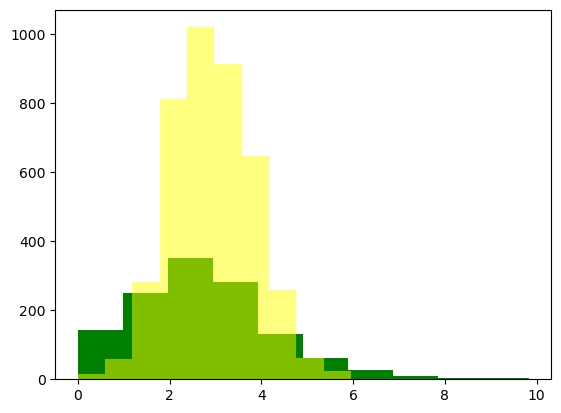

In [6]:
plt.hist(train_cost_df["cost"], bins=10, color="green")
plt.hist(inference_cost_df["traversal_cost"], color="yellow", alpha=0.5)

# Images inputted to the vision model
- Not enough data (< 200 images)
- Gravel and road image patches are hard to distinguish => need bigger patch to include more context

# Theorical loss of a dummy model (e.g. predict the mean of the training set)

(array([4.900e+02, 6.770e+02, 9.210e+02, 1.423e+03, 2.042e+03, 2.249e+03,
        1.941e+03, 1.285e+03, 7.440e+02, 3.040e+02, 1.970e+02, 1.040e+02,
        5.800e+01, 4.300e+01, 3.700e+01, 2.400e+01, 2.300e+01, 1.200e+01,
        9.000e+00, 5.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  0.51385425,  1.0277085 ,  1.54156275,  2.055417  ,
         2.56927125,  3.0831255 ,  3.59697975,  4.110834  ,  4.62468825,
         5.1385425 ,  5.65239675,  6.166251  ,  6.68010525,  7.1939595 ,
         7.70781375,  8.221668  ,  8.73552225,  9.2493765 ,  9.76323075,
        10.277085  , 10.79093925, 11.3047935 , 11.81864775, 12.332502  ,
        12.84635625, 13.3602105 , 13.87406475, 14.387919  , 14.90177325,
        15.4156275 ]),
 <a list of 30 Patch objects>)

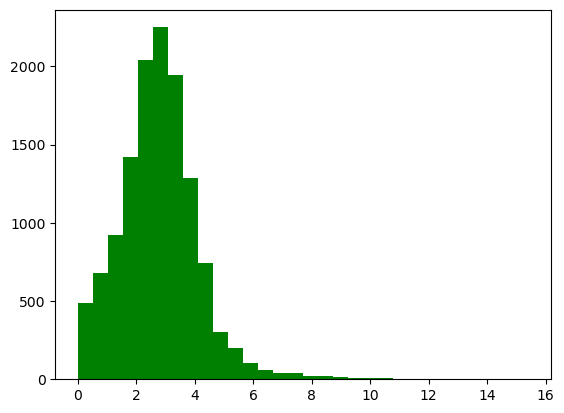

In [5]:
train_cost = (
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered/traversal_costs.csv"
)
df = pd.read_csv(train_cost)

plt.hist(df["traversal_cost"], bins=30, color="green")

In [6]:
# Global mean
np.mean((df["traversal_cost"] - df["traversal_cost"].mean()) ** 2)

1.8848094532126374

In [14]:
# For a mean per velocity?
df.groupby("linear_velocity")

np.mean(
    [
        np.mean(
            (vel_df["traversal_cost"] - vel_df["traversal_cost"].mean()) ** 2
        )
        for _, vel_df in df.groupby("linear_velocity")
    ]
)

1.5793590902178032

# Which resolutions for patches?
A minimum width of 200 pixels seems a good trade-off to keep a minimum understandable resolution.

In [23]:
def plot_width_distribution(dataset):
    image_dir = PROJECT_PATH / f"datasets/dataset_{dataset}" / "images"
    # XXX: PIL's dimension has (width, height) order
    image_width = [
        Image.open(image_dir / image_name).size[0]
        for image_name in image_dir.glob("*[!nd].png")
    ]

    plt.hist(image_width, bins=30)

    plt.title(f"Image width distribution of\n{dataset}")
    plt.xlabel("Width")
    plt.ylabel("Nb images")


plot_for_all_directory(plot_width_distribution)

# What does the IMU space look like?
The features seems relevant. From the plot bellow, the regression cost seems to fluently follow the main component.
But is using a NN for this task really necessary?

In [ ]:
feature_dir = (
    PROJECT_PATH
    / "src/traversal_cost/datasets/dataset_200Hz_wrap_fft/features"
)
cost_file = (
    PROJECT_PATH
    / "src/traversal_cost/siamese_network/logs/_2023-09-27-12-22-04/costs_df.csv"
)

cost_df = pd.read_csv(cost_file, index_col=0)
cost_df = cost_df[~cost_df["terrain_class"].isin(["sand_hard", "sand_medium"])]
cost_df

terrain_class  linear_velocity      cost
0       grass_easy              0.2  2.332287
1       grass_easy              0.2  2.295089
2       grass_easy              0.2  2.279682
3       grass_easy              0.2  2.335167
4       grass_easy              0.2  2.312038
..             ...              ...       ...
955  forest_leaves              1.0  3.497359
956  forest_leaves              1.0  3.391089
957  forest_leaves              1.0  3.635105
958  forest_leaves              1.0  3.519783
959  forest_leaves              1.0  3.348306

[960 rows x 3 columns]

In [ ]:
def get_features(row: pd.Series) -> np.ndarray:
    features = np.load(feature_dir / f"{row.name:03}.npy")
    return features


cost_df["IMU features"] = cost_df.apply(get_features, axis=1)
cost_df

terrain_class  linear_velocity      cost  \
0       grass_easy              0.2  2.332287   
1       grass_easy              0.2  2.295089   
2       grass_easy              0.2  2.279682   
3       grass_easy              0.2  2.335167   
4       grass_easy              0.2  2.312038   
..             ...              ...       ...   
955  forest_leaves              1.0  3.497359   
956  forest_leaves              1.0  3.391089   
957  forest_leaves              1.0  3.635105   
958  forest_leaves              1.0  3.519783   
959  forest_leaves              1.0  3.348306   

                                          IMU features  
0    [3.256301165627901, 2.0849204320223884, 0.4560...  
1    [1.8148938037860471, 1.0233097706037686, 0.213...  
2    [0.4294608088828442, 0.30374210080107494, 0.49...  
3    [2.5484633707508495, 1.0269815078945463, 0.383...  
4    [0.4775256695705397, 0.3397432059309903, 0.072...  
..                                                 ...  
955  [0.6016500689520513, 0.9963473753447926, 0.955...  
956  [1.9792491282933482, 1.5889099228880939, 0.896...  
957  [1.1883941923119288, 1.6142182401573928, 1.550...  
958  [0.9379748852317534, 1.2466072359375384, 1.156...  
959  [1.4423898368046375, 2.65863775641049, 3.94288...  

[960 rows x 4 columns]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
# perform dimension reduction with pca
pca.fit(np.stack(cost_df["IMU features"].values))
# transform the features
reduced_features = pca.transform(np.stack(cost_df["IMU features"].values))
reduced_features.shape

(960, 3)

In [ ]:
pca.explained_variance_ratio_

array([0.77548032, 0.12085436, 0.05124565])

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    reduced_features,
    x=0,
    y=1,
    z=2,
    # color=cost_df["terrain_class"],
    color=cost_df["cost"],
    title="PCA of IMU features",
    labels={"0": "PC1", "1": "PC2", "2": "PC3"},
)
fig.show()

# Velocity Representation in vision dataset
Need to balance more images. 0.6m/s is overrepresented, while 0.2 is clearly underrepresented.

In [6]:
def plot_velocity_representation(cost_df: pd.DataFrame):
    cost_df["velocity_group"] = group_by_velocity(cost_df)
    samples_per_velocity = (
        cost_df[["velocity_group", "traversal_cost"]]
        .groupby("velocity_group")
        .count()
        .values.flatten()
    )
    plt.bar(VELOCITY_VALUES, samples_per_velocity, width=0.1)
    plt.xlabel("Velocity")
    plt.ylabel("Number of samples")

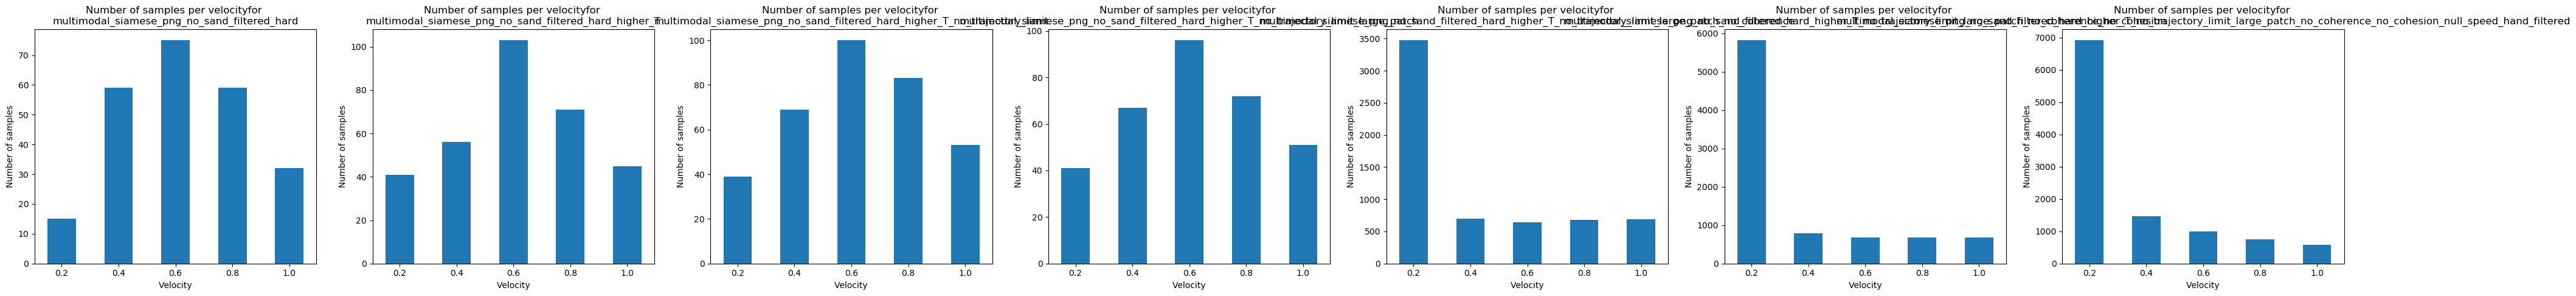

In [7]:
def tmp_plot(dataset: str):
    DATASET = PROJECT_PATH / f"datasets/dataset_{dataset}"
    train_csv = DATASET / "traversal_costs_train.csv"

    cost_df = pd.read_csv(train_csv)

    plot_velocity_representation(cost_df)
    plt.title(f"Number of samples per velocityfor \n{dataset}")


plot_for_all_directory(tmp_plot)

# Cost distribution mismatch between ground truth and prediction of the vision model
Predictions based exclusively on the velocity. Not enough images for the CNN to learn? Or need to change the model?

In [25]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import params.visualparams
import params.learning
from params import PROJECT_PATH
from model import ResNet18Velocity_Regression_Alt

from dataset import get_sets
from utils.dataset import _set_to_loader

LEARNING_PARAMS = params.learning.LEARNING
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS


def get_model(directory):
    model = ResNet18Velocity_Regression_Alt()
    WEIGHTS = (
        PROJECT_PATH
        / f"src/models_development/multimodal_velocity_regression_alt/logs/{directory}/network.params"
    )
    model.load_state_dict(torch.load(WEIGHTS))
    model.eval()
    return model.to("cuda")

In [18]:
from itertools import starmap


def get_terrain_samples(df, traversal_cost: float, linear_velocity: int):
    """
    Find the single terrain sample corresponding to the given traversal costs and linear velocities
    in the given dataframe df.
    """
    return Path(
        df.loc[
            (df["traversal_cost"] == traversal_cost)
            & (df["linear_velocity"] == linear_velocity),
            "source_bagfile",
        ].values[0]
    ).stem


def get_cost_df(model, test_loader, *, device="cuda"):
    cost_df = pd.DataFrame(
        columns=[
            "linear_velocity",
            "traversal_cost",
            "predicted_traversal_cost",
            "terrain_samples",
        ]
    )

    for images, traversal_costs, linear_velocities in test_loader:
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        linear_velocities = linear_velocities.type(torch.float32).to(device)

        # Add a dimension to the linear velocities tensor
        linear_velocities.unsqueeze_(1)
        predicted_traversability_cost = model(images, linear_velocities)

        linear_velocities = linear_velocities.cpu().detach().numpy().flatten()
        traversal_costs = traversal_costs.cpu().detach().numpy().flatten()
        predicted_traversability_cost = (
            predicted_traversability_cost.cpu().detach().numpy().flatten()
        )
        terrain_samples = list(
            starmap(
                lambda traversal_cost, linear_velocity: get_terrain_samples(
                    test_loader.dataset.traversal_costs_frame,
                    traversal_cost,
                    linear_velocity,
                ),
                zip(traversal_costs, linear_velocities),
            )
        )

        tmp_df = pd.DataFrame(
            {
                "linear_velocity": linear_velocities,
                "traversal_cost": traversal_costs,
                "predicted_traversal_cost": predicted_traversability_cost,
                "terrain_samples": terrain_samples,
            }
        )
        cost_df = pd.concat([cost_df, tmp_df], ignore_index=True)

    return cost_df

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [05:20<00:00, 80.04s/it]


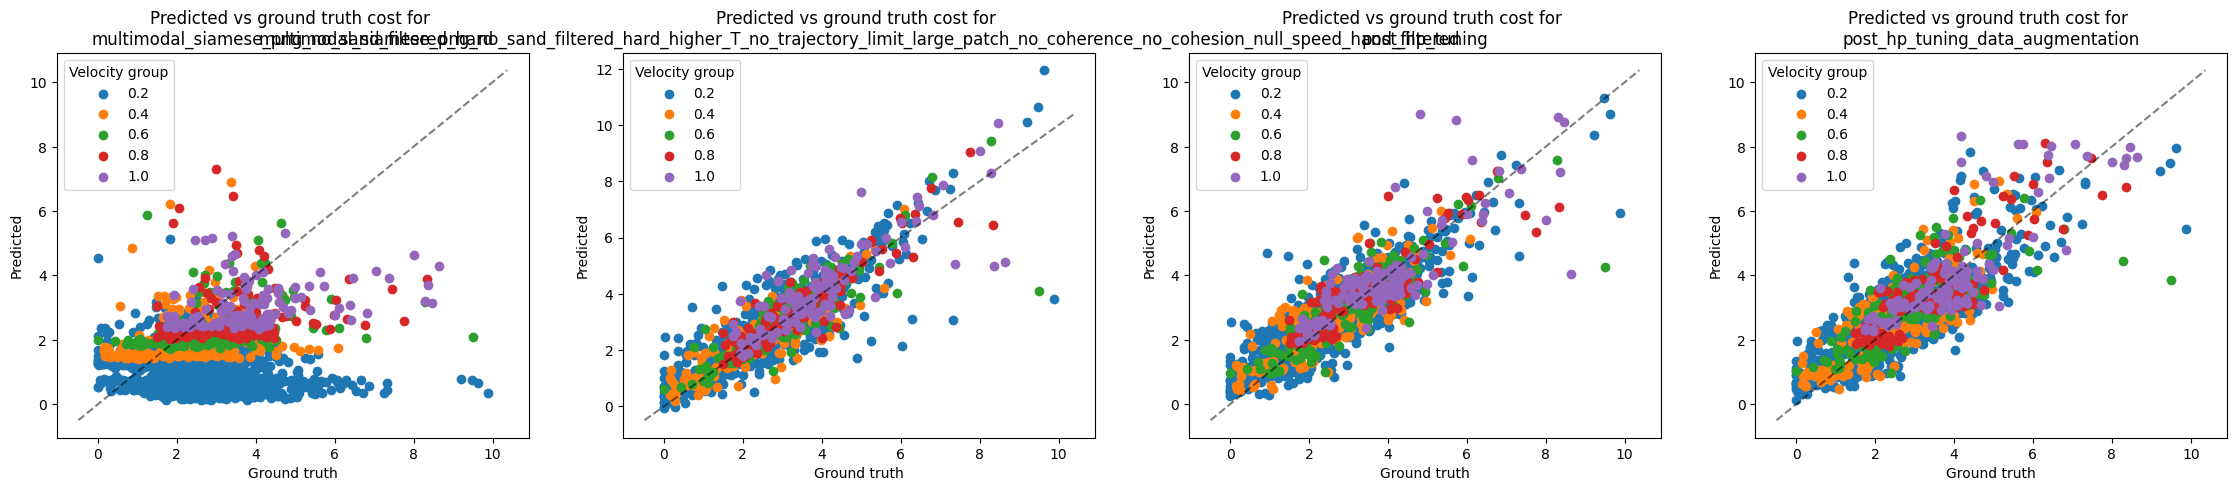

In [7]:
def plot_pred_vs_gt_cost_by_velocity(cost_df):
    cost_df["velocity_group"] = group_by_velocity(cost_df)

    for group, data in cost_df.groupby("velocity_group"):
        plt.scatter(
            data["traversal_cost"],
            data["predicted_traversal_cost"],
            label=group,
        )

    plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--", alpha=0.5)

    plt.xlabel("Ground truth")
    plt.ylabel("Predicted")
    plt.legend(title="Velocity group")


def tmp_plot(directory: str):
    model = get_model(directory)
    _, _, test_set = get_sets(
        PROJECT_PATH
        / "datasets/dataset_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered"
    )
    test_loader = _set_to_loader(test_set, shuffle=False)

    cost_df = get_cost_df(model, test_loader)
    plot_pred_vs_gt_cost_by_velocity(cost_df)
    plt.title(f"Predicted vs ground truth cost for \n{directory}")


plot_for_all_directory(tmp_plot)

Text(0.5, 1.0, 'Predicted vs ground truth cost for \npost_hp_tuning_data_augmentation_no_normalisation')

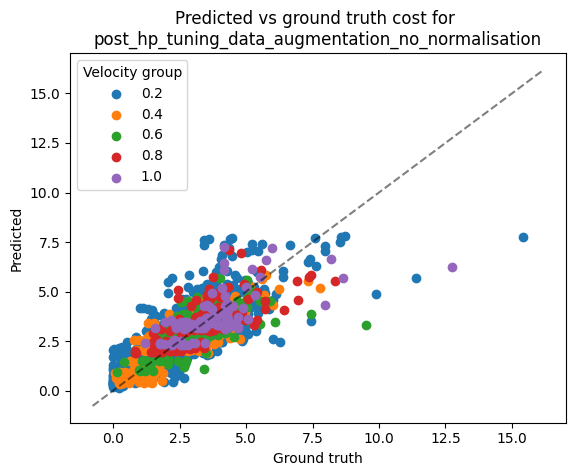

In [11]:
directory = "_post_hp_tuning_data_augmentation_no_normalisation"
model = get_model(directory)
_, _, test_set = get_sets(
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered",
    multimodal_transform=transforms.Resize(
        params.learning.IMAGE_SHAPE, antialias=True
    ),
)
test_loader = _set_to_loader(test_set, shuffle=False)

cost_df = get_cost_df(model, test_loader)
plot_pred_vs_gt_cost_by_velocity(cost_df)
plt.title(f"Predicted vs ground truth cost for \n{directory}")

In [33]:
from torch.nn.functional import mse_loss


def plot_pred_vs_gt_cost_by_terrain(cost_df_dict, *, nrows=3, nb_terrain=12):
    _, ax_list = plt.subplots(
        nrows=nrows,
        ncols=nb_terrain // nrows,
        figsize=(6 * nb_terrain // nrows, 6 * nrows),
    )

    for name, cost_df in cost_df_dict.items():
        for ax, (terrain, data) in zip(
            ax_list.flatten(), cost_df.groupby("terrain_samples")
        ):
            mse = mse_loss(
                torch.tensor(data["traversal_cost"].values),
                torch.tensor(data["predicted_traversal_cost"].values),
            ).item()
            ax.scatter(
                data["traversal_cost"],
                data["predicted_traversal_cost"],
                label=f"{name} (MSE: {mse:.2f})",
            )
            ax.set_title(terrain)

    for ax in ax_list.flatten():
        # ax.set_xlim(-0.5, 10.5)
        # ax.set_ylim(-0.5, 10.5)
        ax.set_xlim(-0.1, 1)
        ax.set_ylim(-0.1, 1)
        ax.plot(
            ax.get_xlim(),
            ax.get_xlim(),
            color="black",
            linestyle="--",
            alpha=0.5,
        )

        ax.set_xlabel("Ground truth")
        ax.set_ylabel("Predicted")
        ax.legend(title="Models")

## Formula-based traversal cost

In [ ]:
model = model = get_model("formula_hp_tuning/0.0234")

_, _, test_set = get_sets(
    PROJECT_PATH
    / "datasets/dataset_multimodal_formula_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered",
)
test_loader = _set_to_loader(test_set, shuffle=False)

cost_df = get_cost_df(model, test_loader)

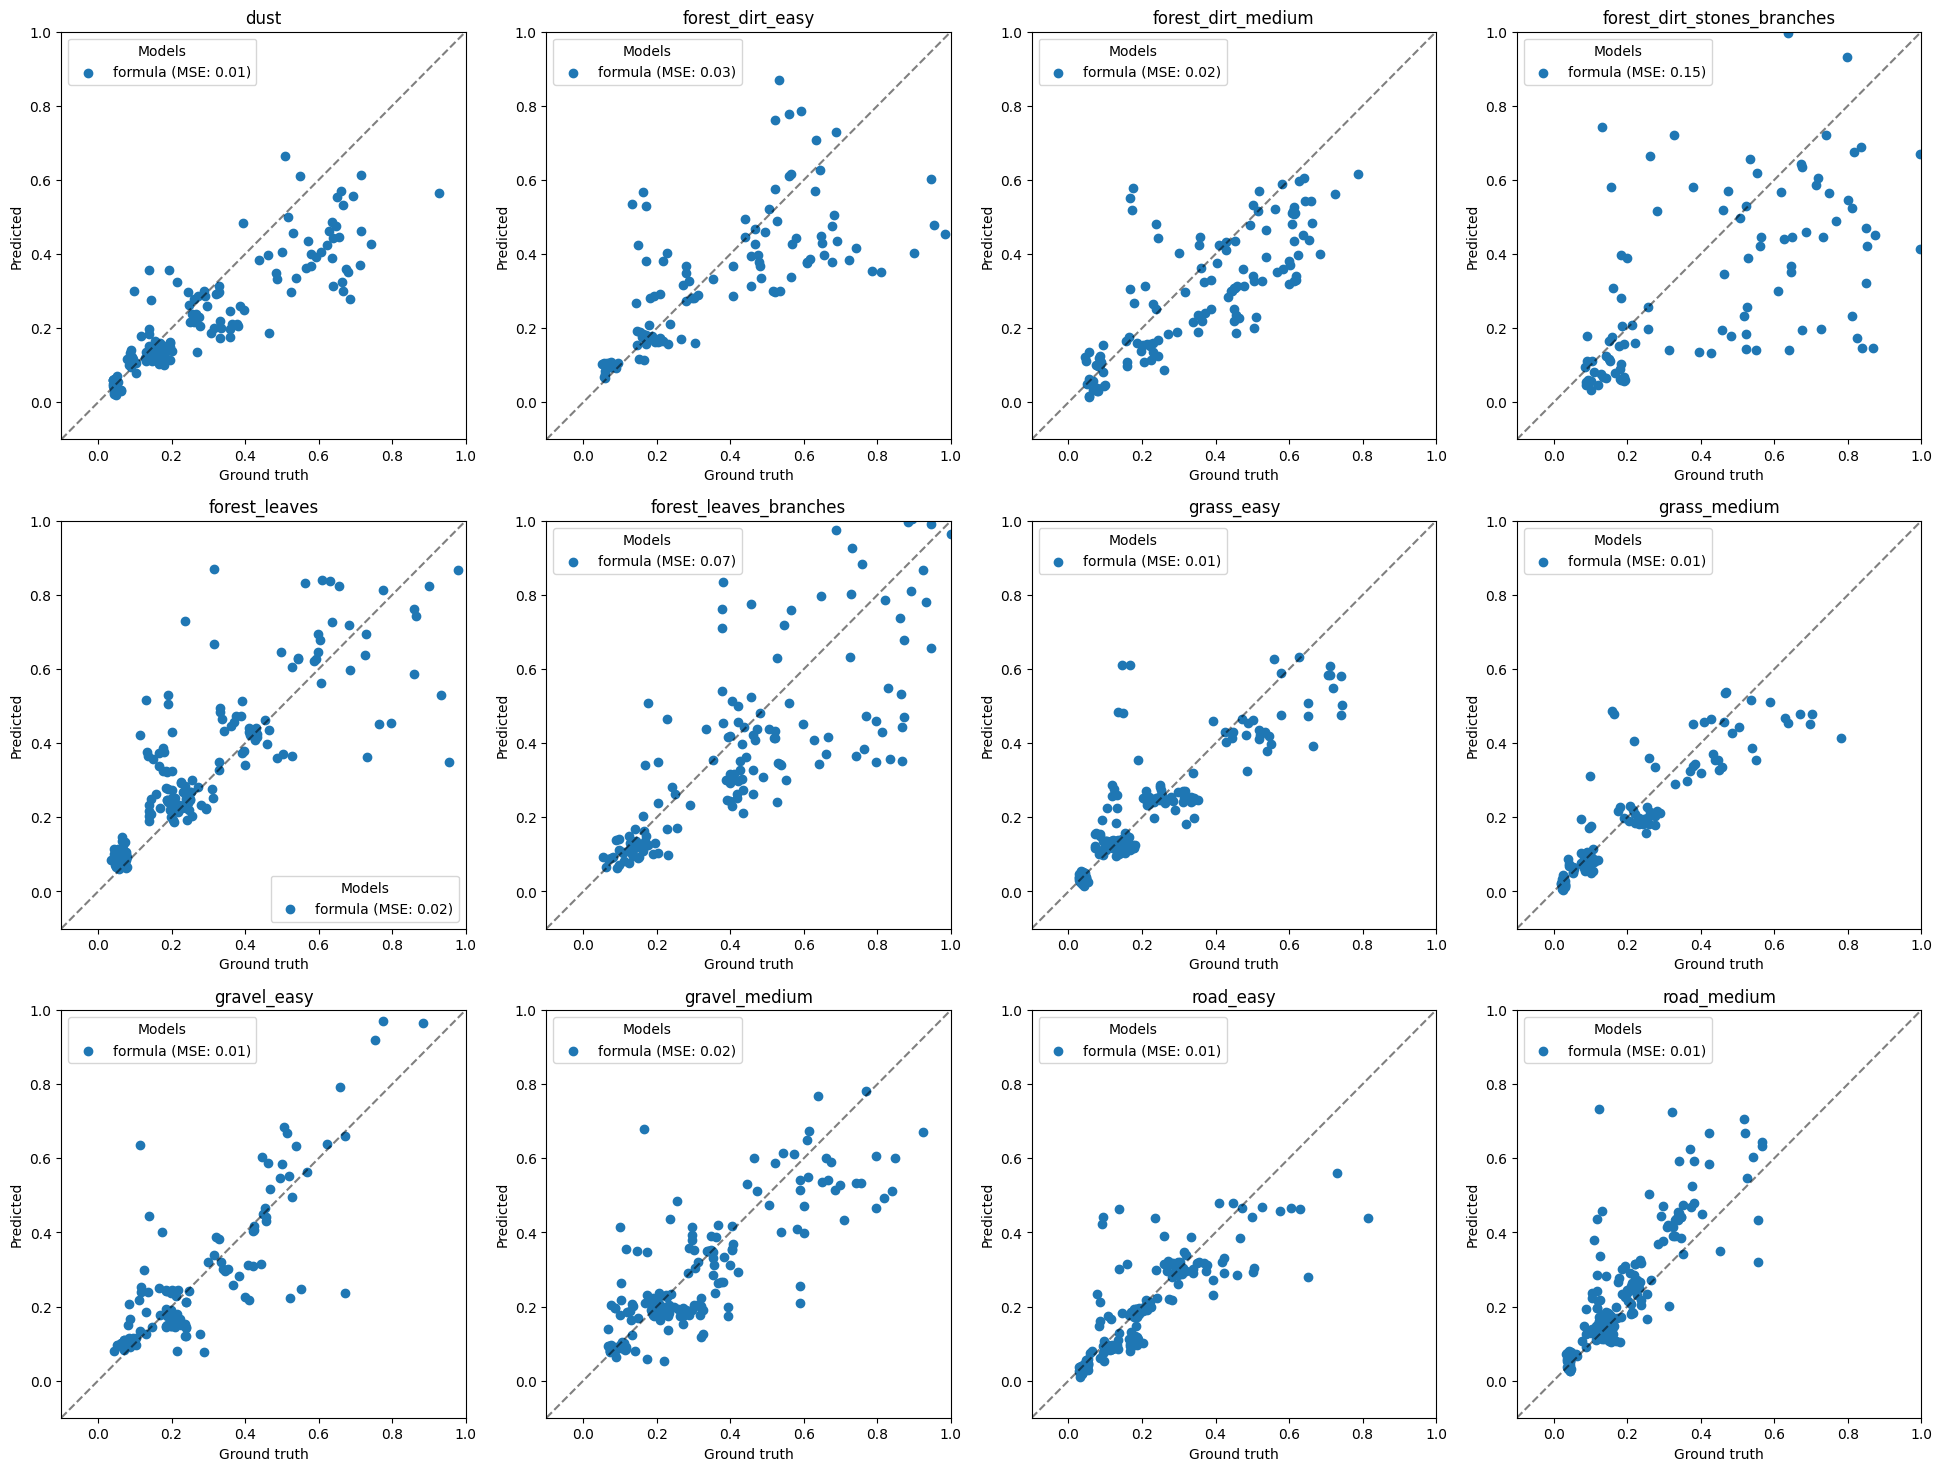

In [34]:
plot_pred_vs_gt_cost_by_terrain(
    {
        "formula": cost_df,
    }
)

## Siamese-based traversal cost

In [76]:
def model_name_to_cost_df(directory: str) -> pd.DataFrame:
    model = get_model(directory)

    _, _, test_set = get_sets(
        PROJECT_PATH
        / "datasets/dataset_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered"
    )
    test_loader = _set_to_loader(test_set, shuffle=False)

    return get_cost_df(model, test_loader)


hp_data_aug_cost_df = model_name_to_cost_df(
    "_post_hp_tuning_data_augmentation"
)
hp_cost_df = model_name_to_cost_df("_post_hp_tuning")

In [ ]:
unormalized_model = get_model(
    "_post_hp_tuning_data_augmentation_no_normalisation"
)
_, _, test_set = get_sets(
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered",
    multimodal_transform=transforms.Resize(
        params.learning.IMAGE_SHAPE, antialias=True
    ),
)
unormalized_test_loader = _set_to_loader(test_set, shuffle=False)

unormalized_hp_data_aug_cost_df = get_cost_df(
    unormalized_model, unormalized_test_loader
)

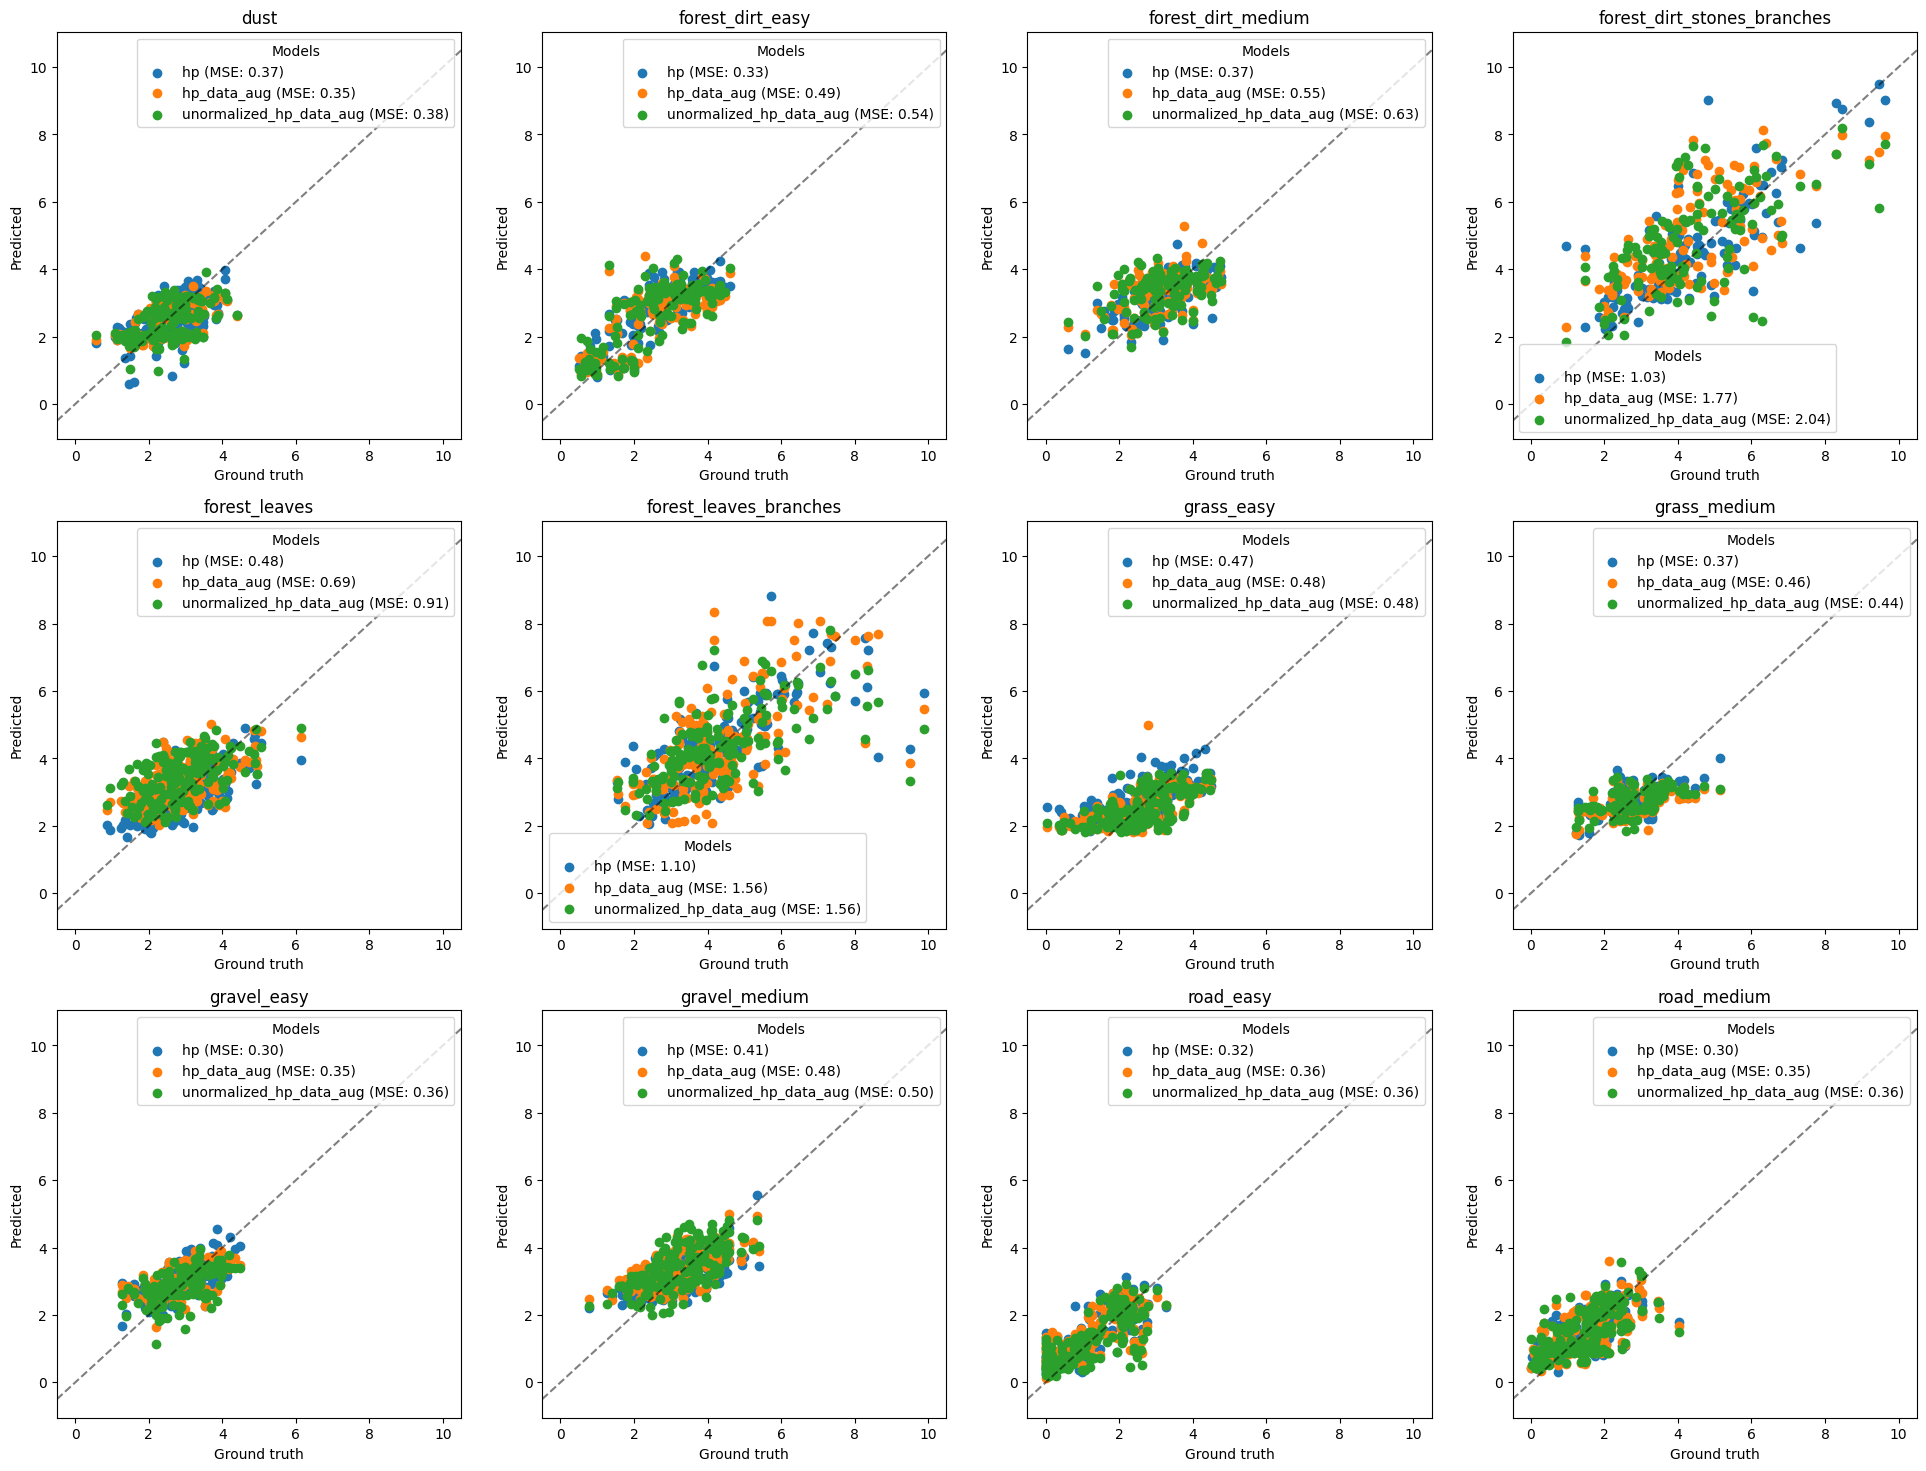

In [97]:
plot_pred_vs_gt_cost_by_terrain(
    {
        "hp": hp_cost_df,
        "hp_data_aug": hp_data_aug_cost_df,
        "unormalized_hp_data_aug": unormalized_hp_cost_df,
    }
)

# Which data-augmentation to use to simulate shadows?

In [5]:
from PIL import Image
from torchvision import transforms
from ipywidgets import interact

img_path = PROJECT_PATH / "bagfiles/images_extracted/3.png"
img = Image.open(img_path)


@interact(
    brightness=(0, 2, 0.1),
    contrast=(0, 2, 0.1),
    saturation=(0, 2, 0.1),
    hue=(-0.5, 0.5, 0.05),
)
def plot_image(
    brightness: float, contrast: float, saturation: float, hue: float
):
    transformed_img = transforms.ColorJitter(
        brightness=(brightness, brightness),
        contrast=(contrast, contrast),
        saturation=(saturation, saturation),
        hue=(hue, hue),
    )(img)
    plt.imshow(transformed_img)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='brightness', max=2.0), FloatSlider(value=1.0, descri…

# Why vision-based datasets are so small?

## Why is the "Terrain_samples" and "road_grass" datasets almost of the same size?
Terrain_samples should have x2 or x3 more data.

### Recode src/data_preparation/create_dataset.py to understand filters

In [33]:
unlabeled_files = [
    "bagfiles/raw_bagfiles/Terrains_Samples/dust.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_dirt_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_dirt_medium.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_dirt_stones_branches.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_leaves.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_leaves_branches.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/grass_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/grass_medium.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/gravel_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/gravel_medium.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/road_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/road_medium.bag",
]

#### How many images at the beginning?

In [ ]:
def count_images(file: str) -> int:
    bag = rosbag.Bag(str(PROJECT_PATH / file))
    return bag.get_message_count(params.robot.IMAGE_TOPIC)


list(map(count_images, unlabeled_files))

[466, 504, 497, 483, 476, 491, 481, 476, 489, 483, 482, 471]

In [ ]:
sum(map(count_images, unlabeled_files))

5799

#### Images per terrain class

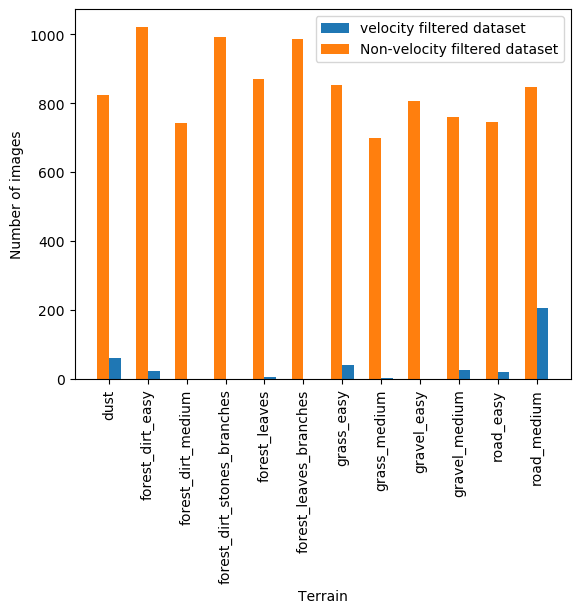

In [7]:
# Values computed by hand, by printing in "src/data_preparation/create_dataset.py:DatasetBuilder.write_images_and_compute_features()"
velocity_filter_nb_images = {
    "dust": 60,
    "forest_dirt_easy": 24,
    "forest_dirt_medium": 0,
    "forest_dirt_stones_branches": 0,
    "forest_leaves": 4,
    "forest_leaves_branches": 0,
    "grass_easy": 41,
    "grass_medium": 3,
    "gravel_easy": 0,
    "gravel_medium": 26,
    "road_easy": 20,
    "road_medium": 207,
}

# i.e. without coherence filtering
non_velocity_filter_nb_images = {
    "dust": 824,
    "forest_dirt_easy": 1022,
    "forest_dirt_medium": 742,
    "forest_dirt_stones_branches": 993,
    "forest_leaves": 872,
    "forest_leaves_branches": 987,
    "grass_easy": 854,
    "grass_medium": 698,
    "gravel_easy": 806,
    "gravel_medium": 760,
    "road_easy": 747,
    "road_medium": 846,
}

# bar plot of the number of images per terrain
plt.bar(
    range(len(velocity_filter_nb_images)),
    velocity_filter_nb_images.values(),
    width=0.3,
    align="edge",
    label="velocity filtered dataset",
)
plt.bar(
    range(len(non_velocity_filter_nb_images)),
    non_velocity_filter_nb_images.values(),
    width=-0.3,
    align="edge",
    label="Non-velocity filtered dataset",
)
plt.xticks(
    range(len(velocity_filter_nb_images)),
    velocity_filter_nb_images.keys(),
    rotation=90,
)
plt.xlabel("Terrain")
plt.ylabel("Number of images")
plt.legend()

#### Bag healthiness check
Does not remove any bag from "terrain_samples".

In [ ]:
import params.dataset


def is_bag_healthy(file: str) -> bool:
    """Check if a bag file is healthy

    Args:
        file (str): Path to the bag file

    Returns:
        bool: True if the bag file is healthy, False otherwise
    """
    bag = rosbag.Bag(str(PROJECT_PATH / file))
    duration = bag.get_end_time() - bag.get_start_time()  # [seconds]

    for topic, frequency in [
        (params.robot.IMAGE_TOPIC, params.robot.CAMERA_SAMPLE_RATE),
        (params.robot.DEPTH_TOPIC, params.robot.DEPTH_SAMPLE_RATE),
        (params.robot.ODOM_TOPIC, params.robot.ODOM_SAMPLE_RATE),
        (params.robot.IMU_TOPIC, params.robot.IMU_SAMPLE_RATE),
    ]:
        # Get the number of messages in the bag file
        nb_messages = bag.get_message_count(topic)

        # Check if the number of messages is consistent with the frequency
        if (
            np.abs(nb_messages - frequency * duration) / (frequency * duration)
            > params.dataset.NB_MESSAGES_THR
        ):
            return False

    return True


list(map(is_bag_healthy, unlabeled_files))

[True, True, True, True, True, True, True, True, True, True, True, True]

#### Depth match filter
Seems relevant. And only removes 20% or so of the data.

In [ ]:
from tqdm import tqdm

from functools import lru_cache


def get_content_closure(topic: str):
    def get_content(file: str):
        """
        Extract images from a bag file
        """
        bag = rosbag.Bag(str(PROJECT_PATH / file))
        return bag, bag.read_messages(topics=[topic])

    return get_content


images_file_list = tqdm(
    map(get_content_closure(params.robot.IMAGE_TOPIC), unlabeled_files),
    total=len(unlabeled_files),
)

depths_file_list = tqdm(
    map(get_content_closure(params.robot.DEPTH_TOPIC), unlabeled_files),
    total=len(unlabeled_files),
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
import rospy

import itertools


def is_depth_matched(msg, bag) -> bool:
    _, __, time = msg

    return (
        list(
            bag.read_messages(
                topics=[params.robot.DEPTH_TOPIC],
                start_time=time - rospy.Duration(params.dataset.TIME_DELTA),
                end_time=time + rospy.Duration(params.dataset.TIME_DELTA),
            )
        )
        != []
    )


images_file_list, images_file_list_copy = itertools.tee(images_file_list)
depth_filter_images = itertools.starmap(
    lambda bag, images: filter(lambda msg: is_depth_matched(msg, bag), images),
    images_file_list_copy,
)

In [ ]:
@lru_cache
def count_image(iterable) -> int:
    return len(list(iterable))


depth_filter_images, iter_count = itertools.tee(depth_filter_images)

# Ok we loose 20% of the images here, but that's fine
list(map(count_image, iter_count))

100%|██████████| 12/12 [00:57<00:00,  4.81s/it]


[429, 428, 422, 418, 422, 419, 412, 351, 381, 384, 374, 434]

In [ ]:
depth_filter_images, iter_count = itertools.tee(depth_filter_images)
sum(map(count_image, iter_count))

4874

In [ ]:
def count_depths(file: str) -> int:
    bag = rosbag.Bag(str(PROJECT_PATH / file))
    return bag.get_message_count(params.robot.DEPTH_TOPIC)


# There is as many depths as images. So the filter on depth is not correct.
list(map(count_depths, unlabeled_files))

[466, 504, 497, 483, 476, 491, 481, 476, 489, 483, 482, 471]

In [ ]:
def get_timestamp(msg):
    _, __, time = msg
    return time.to_sec()


# XXX: There is a bug here for now: need to rerun cell defining images_file_list
images_file_list, images_file_list_copy = itertools.tee(images_file_list)
images_timestamps = itertools.starmap(
    lambda _, images: map(get_timestamp, images), images_file_list_copy
)

In [ ]:
images_timestamps, iter_count = itertools.tee(images_timestamps)
images_timestamps_list = list(map(list, iter_count))
images_timestamps_list

[[], [], [], [], [], [], [], [], [], [], [], []]

In [ ]:
depths_timestamps = itertools.starmap(
    lambda bag, depths: map(get_timestamp, depths), depths_file_list
)

In [ ]:
depths_timestamps, iter_count = itertools.tee(depths_timestamps)
depths_timestamps_list = list(map(list, iter_count))
depths_timestamps_list

100%|██████████| 12/12 [01:28<00:00,  7.41s/it]


[[1685445787.4866703,
  1685445798.0887895,
  1685445798.424487,
  1685445798.7272491,
  1685445799.0618832,
  1685445799.397077,
  1685445799.7130222,
  1685445800.0379124,
  1685445800.371494,
  1685445800.7189596,
  1685445801.037583,
  1685445801.3862486,
  1685445801.7054148,
  1685445802.0392516,
  1685445802.3928914,
  1685445802.7112708,
  1685445803.0479832,
  1685445803.3813717,
  1685445803.7253296,
  1685445804.0471869,
  1685445804.382009,
  1685445804.7065368,
  1685445805.0602806,
  1685445805.3698692,
  1685445805.7198243,
  1685445806.0439687,
  1685445806.391973,
  1685445806.700385,
  1685445807.0389726,
  1685445807.370356,
  1685445807.7295275,
  1685445808.0365968,
  1685445808.3681316,
  1685445808.7001617,
  1685445809.0712616,
  1685445809.3650422,
  1685445809.7296858,
  1685445810.0402462,
  1685445810.3702965,
  1685445810.7066398,
  1685445811.0485475,
  1685445811.3669462,
  1685445811.712862,
  1685445812.0375435,
  1685445812.365691,
  1685445812.699354,

In [ ]:
depths_timestamps_list[0][-1] - depths_timestamps_list[0][0]

166.23482871055603

In [16]:
# Most images are not matched with a depth
import plotly.express as px

images = np.array(images_timestamps_list[0])
depths = np.array(depths_timestamps_list[0])

mismatch = images - depths
plt.hist(mismatch, bins=100)
plt.axvline(x=params.dataset.TIME_DELTA, color="r", linestyle="--")
plt.axvline(x=-params.dataset.TIME_DELTA, color="r", linestyle="--")
plt.title("Histogram of the time difference between images and depths")

NameError: name 'images_timestamps_list' is not defined

#### Rover's speed filter
Threshold seems relevant. But, as is, filter out the image when going backward.
Being more flexible on the threshold could x2 the dataset size

##### Are the timestamp of odometry and IMU synchronized?

In [23]:
for file in unlabeled_files:
    bag = rosbag.Bag(str(PROJECT_PATH / file))
    odom_timestamps = [
        t.to_sec()
        for _, _, t in bag.read_messages(topics=[params.robot.ODOM_TOPIC])
    ]
    imu_timestamps = [
        t.to_sec()
        for _, _, t in bag.read_messages(topics=[params.robot.IMU_TOPIC])
    ]

    print(min(odom_timestamps), max(odom_timestamps))
    print(min(imu_timestamps), max(imu_timestamps))

1685445787.260912 1685445954.0057914
1685445787.2491066 1685445954.0174143
1685447047.5194817 1685447215.8287303
1685447047.5093212 1685447215.857581
1685446762.1154947 1685446929.095439
1685446762.1099288 1685446929.1267567


KeyboardInterrupt: 

##### Is the odometry clean?

In [19]:
import plotly.express as px

bag = rosbag.Bag(str(PROJECT_PATH / unlabeled_files[7]))
pose = [
    {
        "x": msg.pose.pose.position.x,
        "y": msg.pose.pose.position.y,
        "z": msg.pose.pose.position.z,
    }
    for _, msg, _ in bag.read_messages(topics=[params.robot.ODOM_TOPIC])
]
pose_df = pd.DataFrame(pose)
print(pose_df["x"].mean(), pose_df["y"].mean())

pose_df["x"] -= pose_df["x"].mean()
pose_df["y"] -= pose_df["y"].mean()

px.line(pose_df)

-275.82126618880136 125.63560778094687


##### Non-null velocity filter

In [ ]:
def is_velocity_positive(msg, bag) -> bool:
    _, _, time = msg
    _, first_msg_odom, _ = next(
        iter(
            bag.read_messages(
                topics=[params.robot.ODOM_TOPIC], start_time=time
            )
        )
    )

    return (
        first_msg_odom.twist.twist.linear.x
        >= params.dataset.LINEAR_VELOCITY_THR
    )


# XXX: There is a bug here for now: need to rerun cell defining images_file_list
images_file_list, images_file_list_copy = itertools.tee(images_file_list)
velocity_filtered_images = itertools.starmap(
    lambda bag, images: filter(
        lambda msg: is_velocity_positive(msg, bag), images
    ),
    images_file_list_copy,
)

In [ ]:
velocity_filtered_images, iter_count = itertools.tee(velocity_filtered_images)
list(map(count_image, iter_count))

100%|██████████| 12/12 [01:17<00:00,  6.42s/it]


[167, 252, 239, 257, 182, 201, 180, 198, 203, 183, 176, 168]

In [ ]:
velocity_filtered_images, iter_count = itertools.tee(velocity_filtered_images)
sum(map(count_image, iter_count))

2406

##### Odometric's velocity is not clean

In [34]:
import plotly.express as px


def plot_velocity(file):
    first_bag = rosbag.Bag(str(PROJECT_PATH / file))
    velocities = [
        msg.twist.twist.linear.x
        for _, msg, _ in first_bag.read_messages(
            topics=[params.robot.ODOM_TOPIC]
        )
    ]

    fig = px.line(velocities)
    fig.show()


weird_odom_idx = [0, 1, 2, 3, 7, 8, 10]
for file in np.array(unlabeled_files)[weird_odom_idx]:
    plot_velocity(file)

In [41]:
from tqdm import tqdm

bag_dir = PROJECT_PATH / "bagfiles/raw_bagfiles/ENSTA_Campus"
unlabeled_files = list(bag_dir.glob("*.bag"))

get_velocities = {
    file: [
        msg.twist.twist.linear.x
        for _, msg, _ in rosbag.Bag(str(file)).read_messages(
            topics=[params.robot.ODOM_TOPIC]
        )
    ]
    for file in tqdm(unlabeled_files)
}

100%|██████████| 37/37 [00:30<00:00,  1.22it/s]


In [42]:
from ipywidgets import interact


@interact(file=unlabeled_files)
def plot_velocity_from_data(file: str):
    velocities = get_velocities[file]

    plt.plot(velocities)

interactive(children=(Dropdown(description='file', options=(PosixPath('/home/g_thomas/Documents/PRE/bagfiles/r…

##### Velocity coherence filter
Not so much relevant and filters out all the data.

##### Velocity cohesion filter
Does not filter much, but makes sense.

# Is the dataloader slow?
Should we try to load all images at once in a np.array and simply index them in __getitem__ rather than loading them one by one?

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

import os

from dataset import DEFAULT_MULTIMODAL_TRANSFORM


class OldDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """

    def __init__(
        self,
        traversal_costs_file: str,
        images_directory: str,
        image_transform: callable = None,
        multimodal_transform: callable = None,
    ) -> None:
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
                images index and their associated traversal cost
            images_directory (string): Directory with all the images
            image_transform (callable, optional): Transforms to be applied on a
                rdg image. Defaults to None.
            multimodal_transform (callable, optional): Transforms to be applied on the
                multimodal image. Defaults to None.
        """
        self.traversal_costs_frame = pd.read_csv(
            traversal_costs_file, converters={"image_id": str}
        )

        self.images_directory = images_directory
        self.image_transform = image_transform
        self.multimodal_transform = multimodal_transform

    def __len__(self) -> int:
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx: int) -> tuple:
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            tuple: Sample at index idx
            ([multimodal_image,
              traversal_cost,
              traversability_label,
              linear_velocity])
        """
        image_name = os.path.join(
            self.images_directory,
            self.traversal_costs_frame.loc[idx, "image_id"],
        )

        image = Image.open(image_name + ".png")
        if self.image_transform:
            image = self.image_transform(image)

        depth_image = Image.open(image_name + "d.png")
        normal_map = Image.open(image_name + "n.png")

        image = transforms.ToTensor()(image)
        depth_image = transforms.ToTensor()(depth_image)
        normal_map = transforms.ToTensor()(normal_map)

        multimodal_image = torch.cat((image, depth_image, normal_map)).float()
        if self.multimodal_transform:
            multimodal_image = self.multimodal_transform(multimodal_image)

        traversal_cost = self.traversal_costs_frame.loc[
            idx, "traversal_cost"
        ].astype(np.float32)
        linear_velocity = self.traversal_costs_frame.loc[
            idx, "linear_velocity"
        ].astype(np.float32)

        return multimodal_image, traversal_cost, linear_velocity


dir = (
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered"
)
set = OldDataset(
    traversal_costs_file=dir / "traversal_costs.csv",
    images_directory=dir / "images",
    image_transform=None,
    multimodal_transform=DEFAULT_MULTIMODAL_TRANSFORM,
)

old_loader = DataLoader(
    set,
    batch_size=32,
    num_workers=12,
    # pin_memory=True,
)

In [13]:
%%timeit 
for _ in old_loader:
    pass

15.9 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
class NewDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """

    def __init__(
        self,
        traversal_costs_file: str,
        images_directory: str,
        image_transform: callable = None,
        multimodal_transform: callable = None,
    ) -> None:
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
                images index and their associated traversal cost
            images_directory (string): Directory with all the images
            image_transform (callable, optional): Transforms to be applied on a
                rdg image. Defaults to None.
            multimodal_transform (callable, optional): Transforms to be applied on the
                multimodal image. Defaults to None.
        """
        self.traversal_costs_frame = pd.read_csv(
            traversal_costs_file,
            converters={"image_id": str},
            dtype={
                "traversal_cost": np.float32,
                "linear_velocity": np.float32,
            },
        )

        self.images_directory = images_directory
        self.image_transform = image_transform
        self.multimodal_transform = multimodal_transform

        self.images = self._get_image_list_with_suffix(".png")
        self.depths = self._get_image_list_with_suffix("d.png")
        self.normals = self._get_image_list_with_suffix("n.png")

    def _get_image_list_with_suffix(self, suffix: str) -> list:
        return [
            self._get_image_with_suffix(suffix, idx)
            for idx in range(len(self))
        ]

    def _get_image_with_suffix(self, suffix: str, idx: int) -> torch.Tensor:
        image_name = os.path.join(
            self.images_directory,
            self.traversal_costs_frame.loc[idx, "image_id"],
        )

        return transforms.ToTensor()(Image.open(image_name + suffix)).float()

    def __len__(self) -> int:
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx: int) -> tuple:
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            tuple: Sample at index idx
            ([multimodal_image,
              traversal_cost,
              traversability_label,
              linear_velocity])
        """
        image = self.images[idx]
        if self.image_transform:
            image = self.image_transform(image)

        depth_image = self.depths[idx]
        normal_map = self.normals[idx]

        multimodal_image = torch.cat((image, depth_image, normal_map))
        if self.multimodal_transform:
            multimodal_image = self.multimodal_transform(multimodal_image)

        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        linear_velocity = self.traversal_costs_frame.loc[
            idx, "linear_velocity"
        ]

        return multimodal_image, traversal_cost, linear_velocity


set = NewDataset(
    traversal_costs_file=dir / "traversal_costs.csv",
    images_directory=dir / "images",
    image_transform=None,
    multimodal_transform=DEFAULT_MULTIMODAL_TRANSFORM,
)

new_loader = DataLoader(
    set,
    batch_size=32,
    num_workers=12,
    # pin_memory=True,
)

In [9]:
%%timeit 
for _ in new_loader:
    pass

6.97 s ± 94.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Linear projection of traversability formula values into the siamese's ones
Is it really relevant?
Might just be more interesting to normalize the MSE by the mean of ground truth traversability.

In [4]:
siamese_costs_path = (
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered/traversal_costs.csv"
)
formula_costs_path = (
    PROJECT_PATH
    / "datasets/dataset_multimodal_formula_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion_null_speed_hand_filtered/traversal_costs.csv"
)

siamese_costs = pd.read_csv(siamese_costs_path)
formula_costs = pd.read_csv(formula_costs_path)

(array([4.900e+02, 6.770e+02, 9.210e+02, 1.423e+03, 2.042e+03, 2.249e+03,
        1.941e+03, 1.285e+03, 7.440e+02, 3.040e+02, 1.970e+02, 1.040e+02,
        5.800e+01, 4.300e+01, 3.700e+01, 2.400e+01, 2.300e+01, 1.200e+01,
        9.000e+00, 5.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  0.51385425,  1.0277085 ,  1.54156275,  2.055417  ,
         2.56927125,  3.0831255 ,  3.59697975,  4.110834  ,  4.62468825,
         5.1385425 ,  5.65239675,  6.166251  ,  6.68010525,  7.1939595 ,
         7.70781375,  8.221668  ,  8.73552225,  9.2493765 ,  9.76323075,
        10.277085  , 10.79093925, 11.3047935 , 11.81864775, 12.332502  ,
        12.84635625, 13.3602105 , 13.87406475, 14.387919  , 14.90177325,
        15.4156275 ]),
 <BarContainer object of 30 artists>)

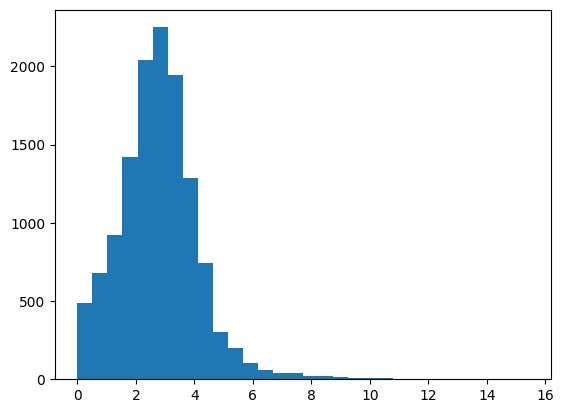

In [14]:
plt.hist(siamese_costs["traversal_cost"], bins=30)

In [7]:
formula_mean, siamese_mean = (
    formula_costs["traversal_cost"].mean(),
    siamese_costs["traversal_cost"].mean(),
)
formula_mean, siamese_mean

(0.3202936318674415, 2.7839800782929562)

In [6]:
best_formula_error = 0.0234
best_siamese_error = 0.79

In [8]:
best_formula_error / formula_mean, best_siamese_error / siamese_mean

(0.07305796204429209, 0.28376639838759254)

In [10]:
np.sqrt(best_formula_error) / formula_mean, np.sqrt(
    best_siamese_error
) / siamese_mean

(0.4775948385732902, 0.3192621415152343)

(array([3.231e+03, 3.146e+03, 1.635e+03, 1.107e+03, 9.760e+02, 7.380e+02,
        6.050e+02, 3.360e+02, 2.220e+02, 1.390e+02, 1.120e+02, 7.100e+01,
        4.900e+01, 3.400e+01, 1.600e+01, 3.300e+01, 2.000e+01, 2.100e+01,
        4.000e+01, 2.400e+01, 1.700e+01, 8.000e+00, 8.000e+00, 7.000e+00,
        2.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([0.01953629, 0.11679646, 0.21405664, 0.31131682, 0.408577  ,
        0.50583718, 0.60309735, 0.70035753, 0.79761771, 0.89487789,
        0.99213806, 1.08939824, 1.18665842, 1.2839186 , 1.38117878,
        1.47843895, 1.57569913, 1.67295931, 1.77021949, 1.86747966,
        1.96473984, 2.06200002, 2.1592602 , 2.25652038, 2.35378055,
        2.45104073, 2.54830091, 2.64556109, 2.74282126, 2.84008144,
        2.93734162]),
 <BarContainer object of 30 artists>)

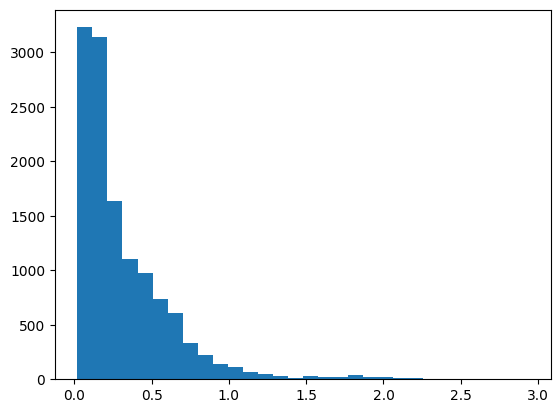

In [27]:
cost = formula_costs["traversal_cost"]
plt.hist(cost, bins=30)

(array([3.231e+03, 3.146e+03, 1.635e+03, 1.107e+03, 9.760e+02, 7.380e+02,
        6.050e+02, 3.360e+02, 2.220e+02, 1.390e+02, 1.120e+02, 7.100e+01,
        4.900e+01, 3.400e+01, 1.600e+01, 3.300e+01, 2.000e+01, 2.100e+01,
        4.000e+01, 2.400e+01, 1.700e+01, 8.000e+00, 8.000e+00, 7.000e+00,
        2.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0.15042941,  0.89933278,  1.64823615,  2.39713952,  3.14604289,
         3.89494625,  4.64384962,  5.39275299,  6.14165636,  6.89055973,
         7.6394631 ,  8.38836647,  9.13726984,  9.88617321, 10.63507658,
        11.38397994, 12.13288331, 12.88178668, 13.63069005, 14.37959342,
        15.12849679, 15.87740016, 16.62630353, 17.3752069 , 18.12411026,
        18.87301363, 19.621917  , 20.37082037, 21.11972374, 21.86862711,
        22.61753048]),
 <BarContainer object of 30 artists>)

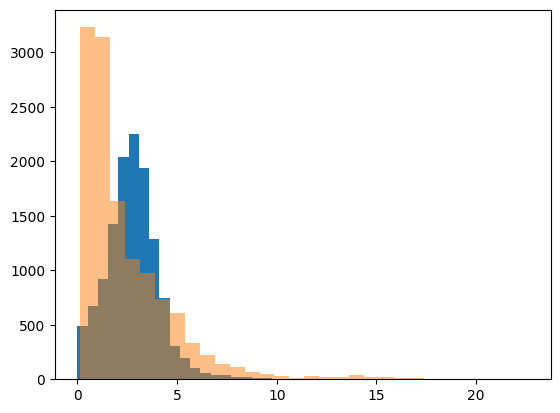

In [26]:
plt.hist(siamese_costs["traversal_cost"], bins=30)
plt.hist(formula_costs["traversal_cost"] * 7.7, bins=30, alpha=0.5)